In [2]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.animation import FuncAnimation

import os
import glob
import pandas as pd
import json
from dotenv import load_dotenv
from functools import partial

In [2]:
def get_db(data_dir):
    json_files = glob.glob(os.path.join(data_dir, "*.json"))
    data_list = []

    # Iterate through the JSON files and read them
    for file in json_files:
        with open(file, 'r') as f:
            data = json.load(f)
            data_list.append(data)

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data_list)
    return df

In [8]:
model = "bruss"
load_dotenv()
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUT_DIR")
output_dir = os.path.join(output_dir, model)
os.makedirs(output_dir, exist_ok=True)
df0 = get_db(os.path.join(data_dir, model))
df0['run_id'].unique()

array([nan, 'sin-src8', 'dist2', 'vary_ab_exp', 'dist', 'vary_a_b',
       'vary_sources', 'vary_du_dv', 'sin-src', 'bruss_blowup'],
      dtype=object)

In [10]:
df = df0.copy()
df = df[(df["run_id"] == 'vary_ab_exp')]
df

,model,A,B,Nx,dx,Nt,dt,Du,Dv,sigma_ic,random_seed,n_snapshots,filename,sigma_ic_u,sigma_ic_v,run_id,num_sources
6,bruss,7.102993e+00,7.102993e+00,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/4445605b-dd...,NaN,NaN,vary_ab_exp,NaN
27,bruss,2.828427e+00,1.414214e+00,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/9b605949-ea...,NaN,NaN,vary_ab_exp,NaN
56,bruss,2.665144e+00,2.665144e+00,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/0d53927c-66...,NaN,NaN,vary_ab_exp,NaN
119,bruss,1.540707e+15,2.311060e+15,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/840a4ecc-34...,NaN,NaN,vary_ab_exp,NaN
161,bruss,1.414214e+00,7.071068e-01,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/448038da-7d...,NaN,NaN,vary_ab_exp,NaN
203,bruss,1.374719e+02,2.062079e+02,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/8d5b84cb-53...,NaN,NaN,vary_ab_exp,NaN
237,bruss,2.828427e+00,1.414214e+00,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/8d55cf89-6c...,NaN,NaN,vary_ab_exp,NaN
262,bruss,2.665144e+00,2.665144e+00,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/a7942d71-b0...,NaN,NaN,vary_ab_exp,NaN
298,bruss,5.656854e+00,2.828427e+00,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/2e625222-a9...,NaN,NaN,vary_ab_exp,NaN
307,bruss,5.656854e+00,2.828427e+00,400,0.5,50000,0.001,2.0,22.0,0.1,1,100,/cluster/scratch/vogtva/data/bruss/38d1feac-a6...,NaN,NaN,vary_ab_exp,NaN


In [5]:
def ab_grid(
    df, component_idx=0, frame=-1, sigdigits=2, var1="A", var2="B", file="", an=False
):
    if len(df) == 0:
        return None

    df = df.sort_values(by=[var1, var2])
    A_count = len(df[var1].unique())
    print(A_count)
    B_count = int(len(df) / A_count)
    print(B_count)
    fig = plt.figure(figsize=(15, 12))
    grid = ImageGrid(fig, 111, nrows_ncols=(A_count, B_count), axes_pad=(0.1, 0.3))

    ims = []

    for i, row in df.iterrows():
        ds = nc.Dataset(row["filename"])

        data = ds.variables["data"][:]
        ims.append((row, data[0, frame, :, component_idx::2]))

    for ax, (row, im) in zip(grid, ims):
        ax.set_title(
            f"{var1}={row[var1]:.{sigdigits}f}\n{var2} = {row[var2]:.{sigdigits}f}",
            fontsize=6,
        )
        ax.imshow(im, cmap="viridis")
        ax.set_aspect("equal")
        ax.axis("off")
    row = df.iloc[0]
    if frame == -1:
        time = row["dt"] * row["Nt"]
    else:
        time = row["dt"] * frame * row["Nt"] / row["n_snapshots"]
    fig.suptitle(
        f"{row['model'].capitalize()}, Nx={row['Nx']}, dx={row['dx']}, dt={row['dt']}, T={time:.2f}",
        fontsize=16,
    )

    if file != "":
        plt.savefig(file, dpi=100)
    if not an:
        plt.show()
    return grid


1
48


KeyboardInterrupt: 

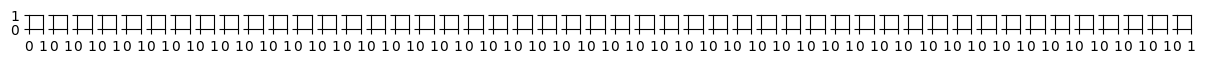

In [6]:
ab_grid(df, 1, frame=-1, sigdigits=3, var1="dt", var2="B")#, file="gray_scott_ab")

In [5]:
def convergence_plot(df, sigdigits=2, var1="A", var2="B", file=""):
    if len(df) == 0:
        return None

    df = df.sort_values(by=[var1, var2])
    df = df.reset_index(drop=True)
    A_count = len(df[var1].unique())
    B_count = int(len(df) / A_count)

    fig, axes = plt.subplots(A_count, B_count, figsize=(3 * B_count + 1, 5 * A_count))
    axes = np.atleast_2d(axes)
    for i, row in df.iterrows():
        ds = nc.Dataset(row["filename"])
        data = ds.variables["data"][:]
        steady_state = np.zeros_like(data[0, 0, :, :])
        steady_state[:, 0::2] = row["A"]
        steady_state[:, 1::2] = row["B"]
        l1 = []
        for j in range(data.shape[1]):
            l1.append(np.linalg.norm(data[0, j, :, :] - steady_state, 1) / np.prod(data.shape[2:]))

        axes[i // B_count, i % B_count].plot(
            np.arange(0, data.shape[1]) * row["dt"] * row["Nt"] / row["n_snapshots"],
            l1,
        )
        axes[i // B_count, i % B_count].set_title(
            f"{var1}={row[var1]:.{sigdigits}f}\n{var2} = {row[var2]:.{sigdigits}f}",
            fontsize=6,
        )
        # axes[i // B_count, i % B_count].axis("off")
    row = df.iloc[0]
    time = row["dt"] * row["Nt"]
    fig.suptitle(
        f"{row['model'].capitalize()}, Nx={row['Nx']}, dx={row['dx']}, dt={row['dt']}, T={time:.2f}",
        fontsize=16,
    )
    plt.tight_layout()
    plt.show()
    if file != "":
        fig.savefig(file, dpi=100)


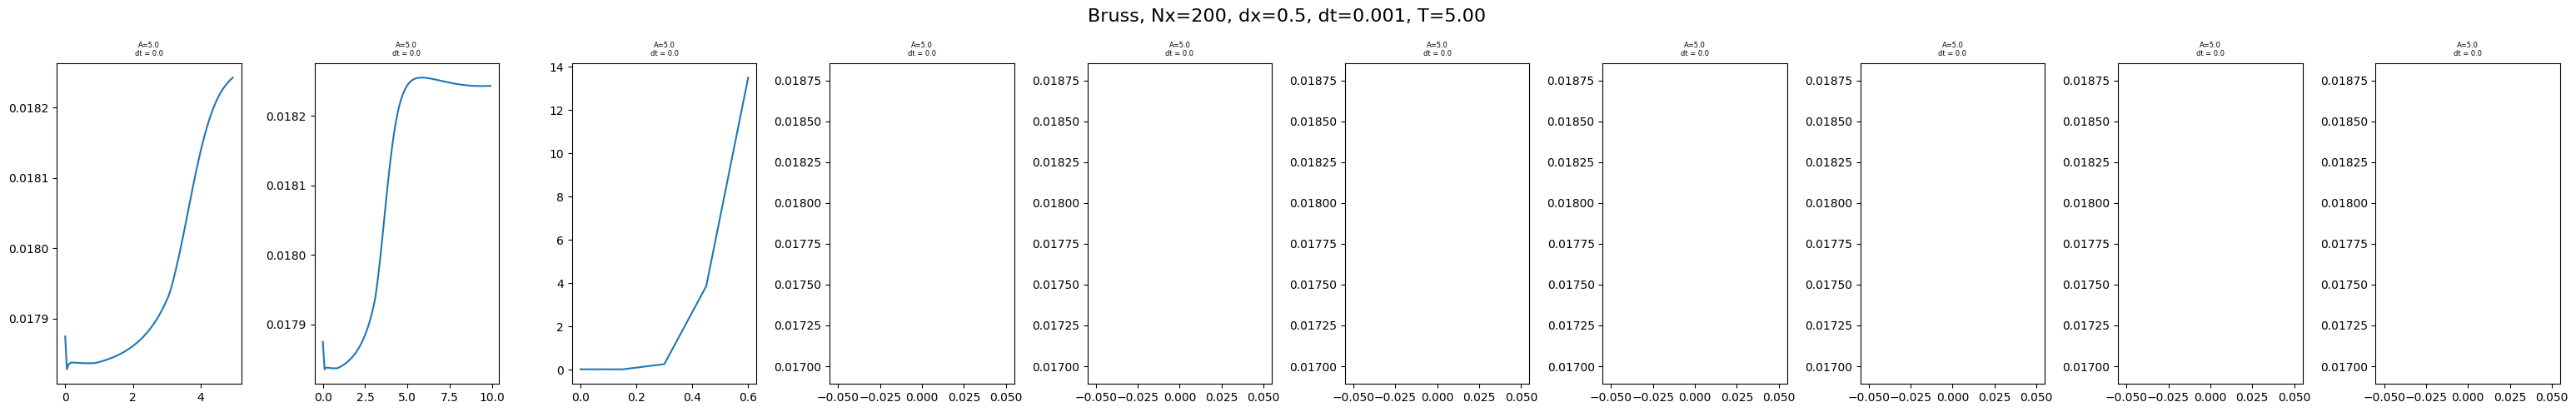

In [7]:
convergence_plot(df, sigdigits=1, var1="A", var2="dt", file="a_b_convergence")